In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.svm import SVR
from scipy.optimize import minimize
from datetime import  timedelta
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.base import clone
simplefilter("ignore", category=ConvergenceWarning)
pd.options.mode.chained_assignment = None

In [2]:
trend_data = pd.read_csv("./train_trendency.csv", index_col=0)
vacc_data = pd.read_csv("./train_vaccine.csv", index_col=0)
test_data = pd.read_csv("./test.csv", index_col=0)
popu_data = pd.read_csv("./population.csv")
sub_data = pd.read_csv("./submission.csv", index_col=0)

In [3]:
trend_data.head()

,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate
0,Alabama,01-12-2021,407848,5573,211684.0,190591.0,8318.021857,1981019.0,1.366440,40402.697430
1,Alaska,01-12-2021,50544,225,7165.0,43132.0,6906.205360,1357708.0,0.445351,185594.597735
2,Arizona,01-12-2021,636100,10482,86757.0,538861.0,8739.177523,5742443.0,1.647854,42806.225328
3,Arkansas,01-12-2021,259553,4121,229700.0,25732.0,8600.724235,2208736.0,1.587730,73190.174047
4,California,01-12-2021,2832085,31345,NaN,2773506.0,7098.216165,36508384.0,1.110900,92397.696784


In [4]:
vacc_data.head()

,date,location,total_vaccinations,people_fully_vaccinated
0,2021-01-12,Alabama,78134.0,7270.0
1,2021-01-12,Alaska,35838.0,5400.0
2,2021-01-12,Arizona,141355.0,8343.0
3,2021-01-12,Arkansas,40879.0,8.0
4,2021-01-12,California,816301.0,100089.0


In [5]:
popu_data.head()

,States,Population
0,Alabama,4903185
1,Alaska,731545
2,Arizona,7278717
3,Arkansas,3017804
4,California,39512223


In [6]:
sub_data.head()

,ID,Confirmed,Deaths
0,0,4.886096e+05,13433.927537
1,1,7.984069e+04,379.604174
2,2,1.120780e+06,22412.918362
3,3,2.668372e+05,5901.680368
4,4,4.362343e+06,73622.852919


In [7]:
trend_data.rename(columns={"Unnamed: 0": "id"}, inplace=True)
vacc_data.rename(columns={"Unnamed: 0": "id", "date": "Date", "location": "Province_State"}, inplace=True)
popu_data.rename(columns={"States": "Province_State"}, inplace=True)
trend_data["Date"] = pd.to_datetime(trend_data["Date"])
vacc_data["Date"] = pd.to_datetime(vacc_data["Date"])
vacc_data.head()

,Date,Province_State,total_vaccinations,people_fully_vaccinated
0,2021-01-12,Alabama,78134.0,7270.0
1,2021-01-12,Alaska,35838.0,5400.0
2,2021-01-12,Arizona,141355.0,8343.0
3,2021-01-12,Arkansas,40879.0,8.0
4,2021-01-12,California,816301.0,100089.0


In [8]:
covid_data = pd.merge(trend_data, vacc_data, on=["Date", "Province_State"], how="outer")
covid_data = pd.merge(covid_data, popu_data, on="Province_State")

Data for 03-30-2021 seem to be incomplete, we could drop that date without significant loss of data.

In [9]:
incomplete_rows = covid_data.index[covid_data['Date'] == '03-31-2021']
covid_data.drop(index=incomplete_rows, inplace=True)
covid_data

,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,total_vaccinations,people_fully_vaccinated,Population
0,Alabama,2021-01-12,407848,5573,211684.0,190591.0,8318.021857,1981019.0,1.366440,40402.697430,78134.0,7270.0,4903185
1,Alabama,2021-01-13,410995,5760,211684.0,193551.0,8382.204628,1989724.0,1.401477,40580.235092,84040.0,9245.0,4903185
2,Alabama,2021-01-14,414583,5945,221961.0,186677.0,8455.381553,1999693.0,1.433971,40783.551916,92300.0,NaN,4903185
3,Alabama,2021-01-15,417528,6030,221961.0,189537.0,8515.444553,2012213.0,1.444215,41038.896146,100567.0,13488.0,4903185
4,Alabama,2021-01-16,420681,6119,221961.0,192601.0,8579.749693,2021123.0,1.454546,41220.614764,NaN,NaN,4903185
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,Wyoming,2021-03-26,56046,695,NaN,NaN,9683.823491,678705.0,1.240053,117269.018711,243336.0,95871.0,578759
3945,Wyoming,2021-03-27,56046,695,NaN,NaN,9683.823491,679984.0,1.240053,117490.008795,243604.0,96104.0,578759
3946,Wyoming,2021-03-28,56046,695,NaN,NaN,9683.823491,679984.0,1.240053,117490.008795,244038.0,96398.0,578759
3947,Wyoming,2021-03-29,56190,695,NaN,NaN,9708.704314,679984.0,1.236875,117490.008795,261950.0,104783.0,578759


In [10]:
covid_data.groupby("Province_State").count()

,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,total_vaccinations,people_fully_vaccinated,Population
Province_State,,,,,,,,,,,,
Alabama,78,78,78,54,54,78,78,78,78,74,73,78
Alaska,78,78,78,9,54,78,78,78,78,74,73,78
Arizona,78,78,78,42,54,78,78,78,78,74,73,78
Arkansas,78,78,78,54,54,78,78,78,78,74,73,78
California,78,78,78,0,54,78,78,78,78,74,73,78
Colorado,78,78,78,42,54,78,78,78,78,74,73,78
Connecticut,78,78,78,41,54,78,78,78,78,74,73,78
Delaware,78,78,78,9,54,78,78,78,78,74,73,78
Florida,78,78,78,0,54,78,78,78,78,74,73,78


In [11]:
# impute recovered and active

In [12]:
# group data by state
states_df = {}
for state in covid_data["Province_State"].unique():
    states_df[state] = covid_data[covid_data["Province_State"] == state]
states_df_og = states_df.copy()

In [13]:
# extract time, active, and death
def fit_state_active(state):
    columns = ["Date", "Deaths"]
    keys = ["Date", "Province_State"]
    X = states_df[state].loc[:,columns]
    X = X.reset_index(drop=True)
    X.loc[:, ["Date"]] = pd.to_datetime(X["Date"]) - pd.to_datetime(X["Date"][0])
    X.loc[:, ["Date"]] = [d.days for d in X["Date"]]
    Y = states_df[state].loc[:,["Active"]]
    Y = Y.reset_index(drop=True)
    train_X, train_Y = X[~pd.isnull(Y["Active"])], Y[~pd.isnull(Y["Active"])]
    test_X, test_Y = X[pd.isnull(Y["Active"])], Y[pd.isnull(Y["Active"])]
    train_X = train_X.to_numpy()
    train_Y = train_Y.to_numpy()
    lm = Ridge()
    lm.fit(train_X, train_Y)
    print(lm.score(train_X, train_Y))
    preds = lm.predict(test_X)
    Y[pd.isnull(Y["Active"])] = preds
    print(Y)
    

In [14]:
# imputer for missing values

# infer recovered cases with confirmed and active cases
def impute_recovered(df):
    missing_rec = df.loc[(~ pd.isna(df["Confirmed"])) & (~ pd.isna(df["Active"])) & (~ pd.isna(df["Deaths"])) & (pd.isna(df["Recovered"]))]
    missing_rec["Recovered"] = missing_rec["Confirmed"] - missing_rec["Active"] - missing_rec["Deaths"]
    df.update(missing_rec, overwrite=False)
    return df

In [15]:
# infer susceptible with population, confirmed, deaths, and recovered
def impute_susceptible(df):
    df["Susceptible"] = df["Population"] - df["Confirmed"]
    return df

In [16]:
# trim data entries that cannot be implied
def trim_missing(df):
    df = df[~ pd.isna(df["Recovered"])]
    return df

In [17]:
# infer vaccination data from the next day
def infer_with_neighbors(df, entry):
    for index, row in df.iloc[::-1].iterrows():
        prev_index = index - 1
        next_index = index + 1
        if pd.isnull(df.loc[index][entry]):
            if next_index in df.index and not pd.isnull(df.loc[next_index][entry]):
                if prev_index in df.index and not pd.isnull(df.loc[prev_index][entry]):
                    df.loc[index, [entry]] = (df.loc[next_index][entry] + df.loc[prev_index][entry])/2
                else:
                    df.loc[index, [entry]] = df.loc[next_index][entry]
            else:
                df.loc[index, [entry]] = 0
                print(next_index, df.index)
    return df

In [18]:
for state in states_df:
    states_df[state] = infer_with_neighbors(infer_with_neighbors(trim_missing(impute_recovered(impute_susceptible(states_df[state]))), "total_vaccinations"), "people_fully_vaccinated")

2503 Int64Index([2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459,
            2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470,
            2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481,
            2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492,
            2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502],
           dtype='int64')
2503 Int64Index([2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459,
            2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470,
            2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481,
            2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492,
            2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502],
           dtype='int64')


In [19]:
states_df["California"].dtypes

Province_State                     object
Date                       datetime64[ns]
Confirmed                           int64
Deaths                              int64
Recovered                         float64
Active                            float64
Incident_Rate                     float64
Total_Test_Results                float64
Case_Fatality_Ratio               float64
Testing_Rate                      float64
total_vaccinations                float64
people_fully_vaccinated           float64
Population                          int64
Susceptible                         int64
dtype: object

In [20]:
for state in states_df:
    states_df[state] = states_df[state].drop(columns=["Incident_Rate", "Total_Test_Results", "Case_Fatality_Ratio", "Testing_Rate",  "Population", "total_vaccinations"])
    states_df[state] =  states_df[state].astype({
        "Recovered": "int64", 
        "Active": "int64", 
        "Susceptible": "int64", 
        "people_fully_vaccinated": "int64"
    })
    states_df[state].rename(columns={"people_fully_vaccinated": "Vaccinated"}, inplace=True)
    states_df[state].reset_index(drop=True, inplace=True)
    
states_df["California"].dtypes

Province_State            object
Date              datetime64[ns]
Confirmed                  int64
Deaths                     int64
Recovered                  int64
Active                     int64
Vaccinated                 int64
Susceptible                int64
dtype: object

In [21]:
states_df["California"]

,Province_State,Date,Confirmed,Deaths,Recovered,Active,Vaccinated,Susceptible
0,California,2021-01-12,2832085,31345,27234,2773506,100089,36680138
1,California,2021-01-13,2870104,31871,26855,2811378,133689,36642119
2,California,2021-01-14,2910044,32517,26146,2851381,169031,36602179
3,California,2021-01-15,2948054,33192,25174,2889688,204374,36564169
4,California,2021-01-16,2983149,33574,23120,2926455,232606,36529074
5,California,2021-01-17,3014428,33810,22502,2958116,260838,36497795
6,California,2021-01-18,3043005,33961,23032,2986012,260838,36469218
7,California,2021-01-19,3078551,34656,22768,3021127,260838,36433672
8,California,2021-01-20,3097632,35277,22603,3039752,273276,36414591
9,California,2021-01-21,3122705,36036,26404,3060265,293834,36389518


In [22]:
# death_labels = {}
# recovered_labels = {}
# active_labels = {}
# vaccine_labels = {}

In [23]:
# thres_death = 2000
# thres_recover = 1000
# thres_active = 100000
# for state in states_df:
#     death_labels[state] = states_df[state]["Deaths"].diff()
#     recovered_labels[state] = states_df[state]["Recovered"].diff()
#     active_labels[state] = states_df[state]["Active"].diff()
#     vaccine_labels[state] = states_df[state]["Vaccinated"].diff()
#     death_labels[state].dropna(inplace=True)
#     recovered_labels[state].dropna(inplace=True)
#     active_labels[state].dropna(inplace=True)
#     vaccine_labels[state].dropna(inplace=True)
#     death_labels[state][(death_labels[state] < 0) | (death_labels[state] >= thres_death)] = np.median(death_labels[state][(death_labels[state] >= 0) & (death_labels[state] < thres_death)])
#     recovered_labels[state][(recovered_labels[state] < 0) | (recovered_labels[state] >= thres_recover)] = np.median(recovered_labels[state][(recovered_labels[state] >= 0) & (recovered_labels[state] < thres_recover)])
#     active_labels[state][(active_labels[state] < 0) | (active_labels[state] >= thres_active)] = np.median(active_labels[state][(active_labels[state] >= 0) & (active_labels[state] < thres_active)])

In [24]:
# death_features = {}
# recovered_features = {}
# active_features = {}
# vaccine_features = {}

In [25]:
# '''
# dI/dt = inf_r * S[i] * I[i] / N - rec_r * I[i]
# dR/dt = rec_r * I[i] - re_i_r * R[i] 
# dD/dt = d_r * I[i]
# for each day
# [      [                                             [
# dI/dt   [ S[i]*I[i]/N  -I[i]   0    0  -S[i] ]      inf_r
# dR/dt = [ 0             I[i] -R[i]  0    0   ]  *   rec_r   
# dD/dt   [ 0              0     0   I[i]  0   ]      re_i_r
# dV/dt = [ 0              0     0    0   S[i] ]      d_r
# ]      ]                                            v_r
#                                                      ]
# '''

# for state in states_df:
#     S = states_df[state]["Susceptible"]
#     I = states_df[state]["Active"]
#     R = states_df[state]["Recovered"]
#     D = states_df[state]["Deaths"]
#     V = states_df[state]["Vaccinated"]
#     N = S + I + R + D + V
#     death_features[state] = pd.DataFrame({'inf_r': [0 for i in D.index], 'rec_r': [0 for i in D.index], 're_i_r': [0 for i in D.index], 'd_r': [I[i] for i in D.index], 'v_r': [0 for i in D.index]}, index=D.index)
#     recovered_features[state] = pd.DataFrame({'inf_r': [0 for i in D.index], 'rec_r': [I[i] for i in D.index], 're_i_r': [R[i] for i in D.index], 'd_r': [0 for i in D.index], 'v_r': [-S[i] for i in D.index]},index=D.index)
#     active_features[state] = pd.DataFrame({'inf_r': [S[i]*I[i]/N[i] for i in D.index], 'rec_r': [-I[i] for i in D.index], 're_i_r': [0 for i in D.index], 'd_r': [0 for i in D.index], 'v_r': [0 for i in D.index]},index=D.index)
#     vaccine_features[state] = pd.DataFrame({'inf_r': [0 for i in D.index], 'rec_r': [0 for i in D.index], 're_i_r': [0 for i in D.index], 'd_r': [0 for i in D.index], 'v_r': [S[i] for i in D.index]}, index=D.index)
#     death_features[state].drop(death_features[state].tail(1).index, inplace=True)
#     recovered_features[state].drop(recovered_features[state].tail(1).index, inplace=True)
#     active_features[state].drop(active_features[state].tail(1).index, inplace=True)
#     vaccine_features[state].drop(vaccine_features[state].tail(1).index, inplace=True)

In [26]:
# X_total = {}
# y_total = {}
# for state in states_df:
#     y_total[state] = pd.concat([death_labels[state] , recovered_labels[state] , active_labels[state], vaccine_labels[state]]).sort_index().reset_index(drop=True)
#     X_total[state] = pd.concat([death_features[state] , recovered_features[state] , active_features[state], vaccine_features[state]]).sort_index().reset_index(drop=True)
# X_total["California"]

In [27]:
# y_total["California"]

In [28]:
# train_rates = {}
# for state in states_df:
#     best_score = 0
#     best_coefs = []
#     for start in range(0, 60, 4):
#         for subsize in range(20, 152, 4):
#             X_state = X_total[state][start:start+subsize]
#             y_state = y_total[state][start:start+subsize]
#             linmd = LinearRegression(positive=True, normalize=True)
#             linmd.fit(X_state, y_state)
#             score = linmd.score(X_total[state], y_total[state])
#             coefs = linmd.coef_
#             if score > best_score:
#                 best_score = score
#                 best_coefs = coefs
#     train_rates[state] = {
#         'inf_r' : best_coefs[0],
#         'rec_r': best_coefs[1],
#         're_i_r': best_coefs[2],
#         'd_r': best_coefs[3],
#         'v_r': best_coefs[4]
#     }
#     print("{}: {}".format(state, best_score))


In [29]:
# linear estimator
def linear(state):
    new_f = states_df_og[state][["Confirmed", "Deaths"]].reset_index(drop=True)
    new_f["Days"] = new_f.index
    features = new_f["Days"].to_numpy().reshape(-1, 1)
    deaths = new_f["Deaths"].to_numpy()
    confirmed = new_f["Confirmed"].to_numpy()
    lr = SVR(kernel='linear', tol=1e-7, C=2)
    lr2 = SVR(kernel='linear', tol=1e-7, C=2)
    lr.fit(features, deaths)
    lr2.fit(features, confirmed)
    preds = lr.predict(features)
    preds2 = lr2.predict(features)
    score1 = mean_absolute_percentage_error(preds, deaths)
    score2 = mean_absolute_percentage_error(preds2, confirmed)
    print(state, score1*100, score2*100)
    new_features = np.linspace(79, 109, 30).reshape(-1, 1)
    deaths_new = lr.predict(new_features)
    confirms_new = lr2.predict(new_features)
    start_date = pd.to_datetime("04-01-2021")
    for i in range(30):
        date = start_date + timedelta(days=i)
        entry = test_data[(test_data["Province_State"]==state) & (pd.to_datetime(test_data["Date"]) ==date)]
        test_id = entry.index[0]
        #sub_data.loc[test_id,["Confirmed"]] = confirms_new[i]
        sub_data.loc[test_id,["Deaths"]] = deaths_new[i]

In [30]:
# autoregressive performance note:
# baseline: 1.99955
# linear on kentucky: 1.85160
#

24 49
Alabama 0.0658294318544324 0.04204111349167012


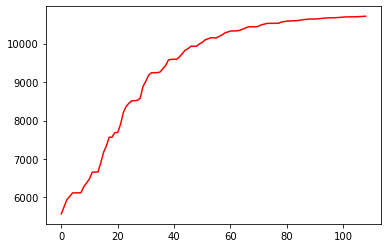

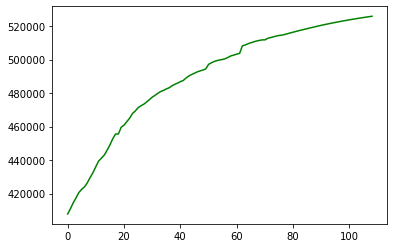

40 48
Alaska 0.08309422312108451 0.09815616922417916


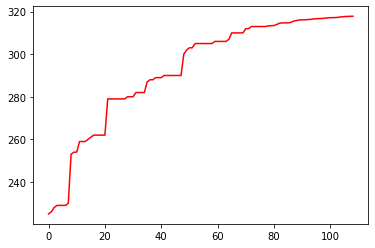

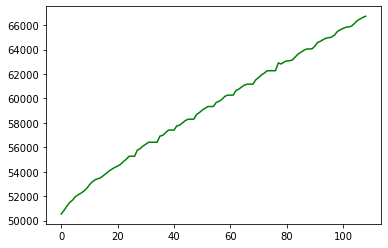

47 49
Arizona 0.029782508982421255 0.07076735457239693


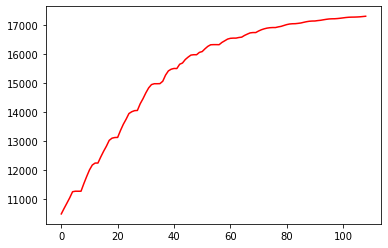

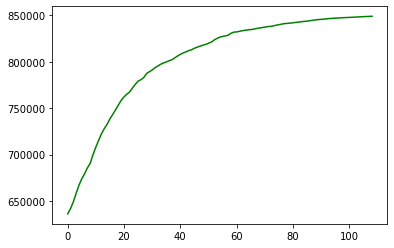

49 49
Arkansas 0.008853383271137945 0.0024508737877119127


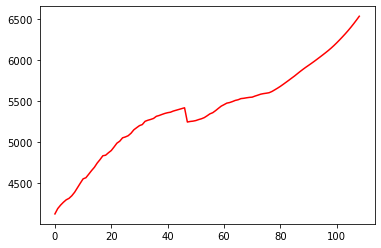

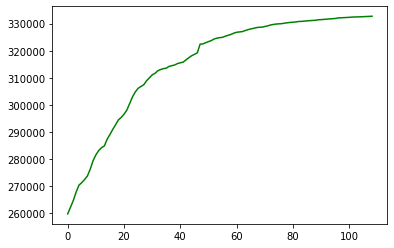

49 48
California 0.014974360445865108 0.06719350649003321


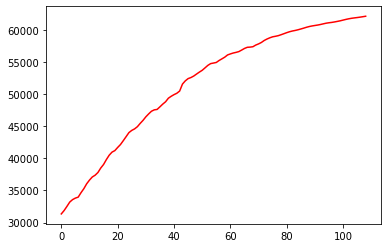

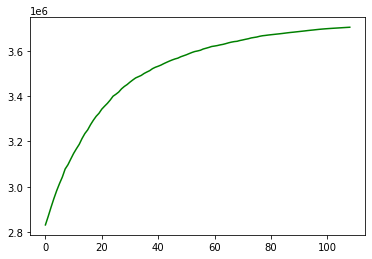

40 42
Colorado 0.04316892753381071 0.04109380896942745


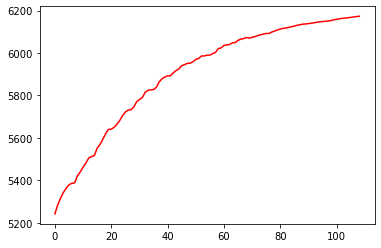

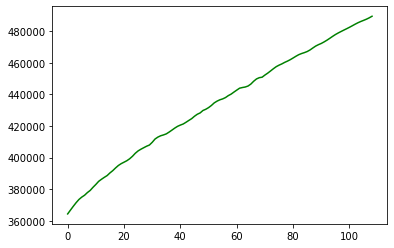

49 45
Connecticut 0.15230373039578315 0.033167800568967794


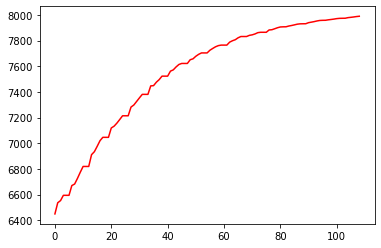

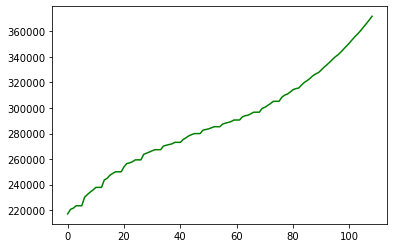

48 49
Delaware 0.0724641059809205 0.12295203040616193


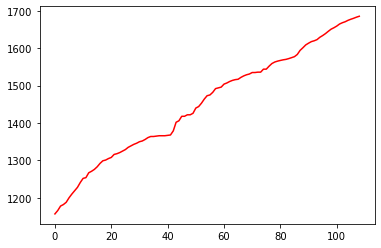

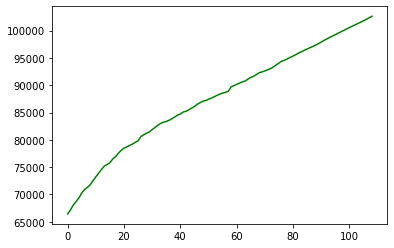

49 49
Florida 0.03772078467768178 0.06142917767182447


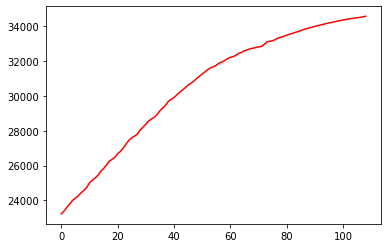

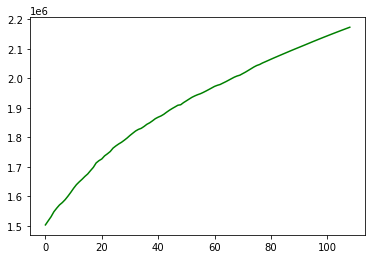

49 49
Georgia 0.02232535739415034 0.09991449005915817


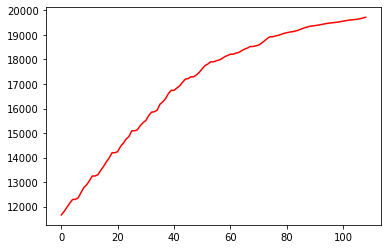

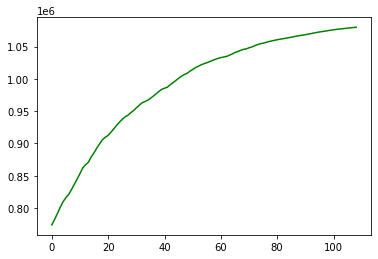

49 47
Hawaii 0.1008197844085779 0.10698996044603015


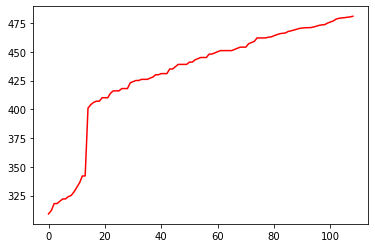

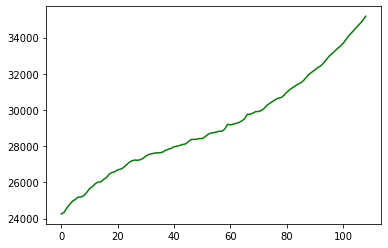

49 46
Idaho 0.03462861027514011 0.11506935090991988


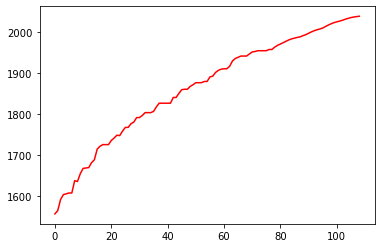

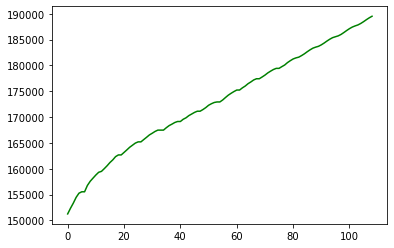

47 49
Illinois 0.027780328408369435 0.02384923534249889


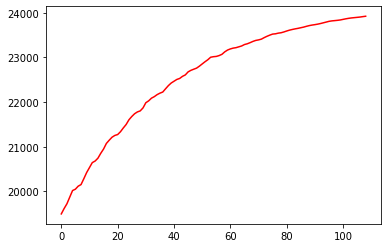

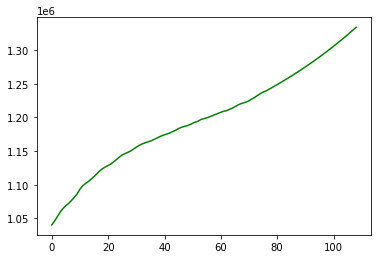

48 49
Indiana 0.015976422507981605 0.022692186564627383


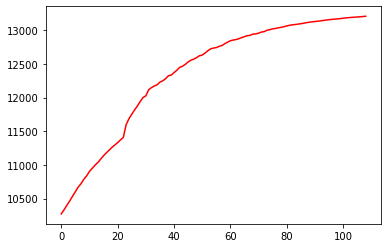

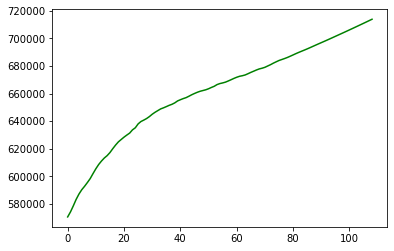

47 49
Iowa 0.03466172545063041 0.07681294718858928


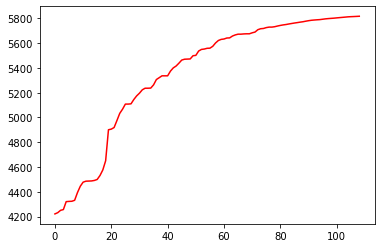

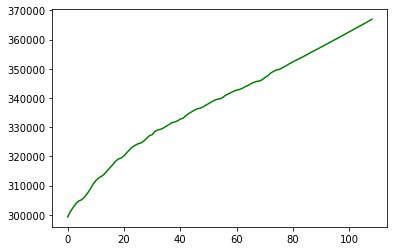

47 49
Kansas 0.02408547642087614 0.15967946177836173


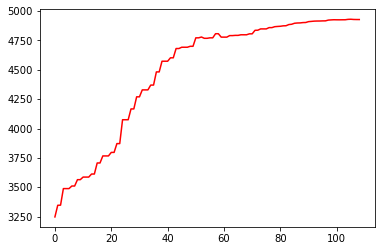

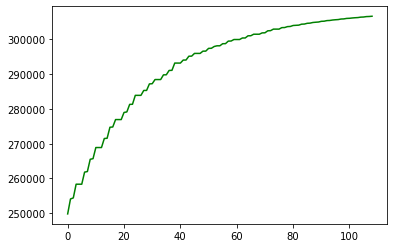

48 5
Kentucky 0.020957869898626517 0.47726453649993283


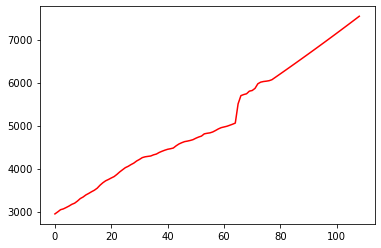

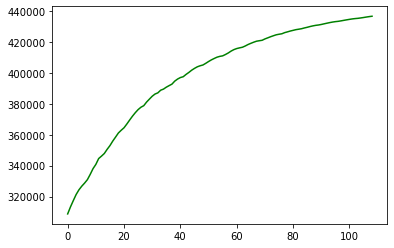

49 49
Louisiana 0.04123636403864511 0.0417081138844556


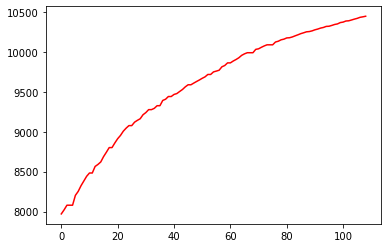

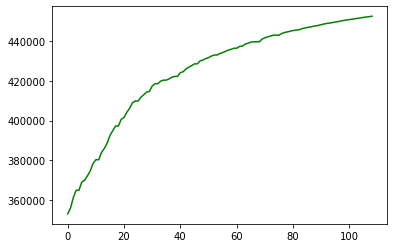

49 45
Maine 0.030660983881815415 0.17887944551017013


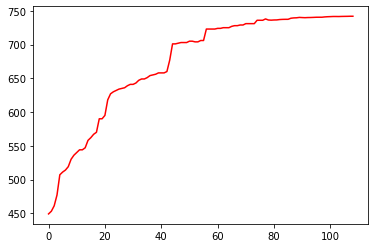

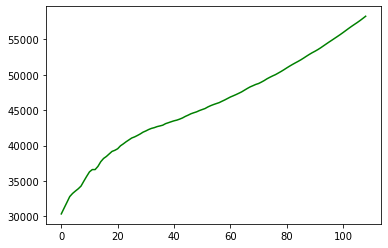

49 48
Maryland 0.02685345144406089 0.05405448038148642


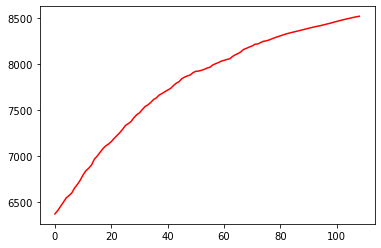

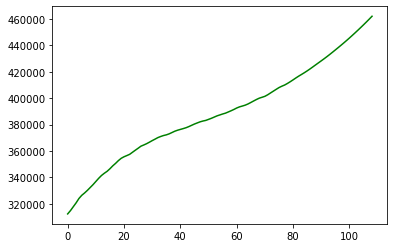

49 47
Massachusetts 0.03652341400663923 0.03322875512648672


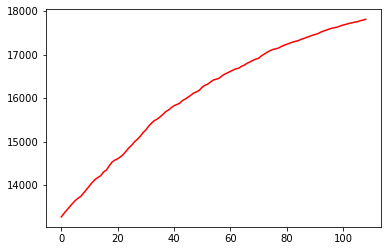

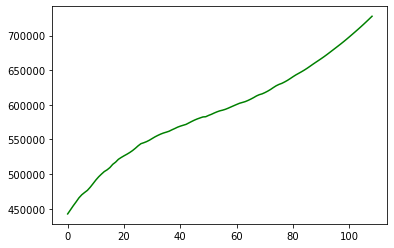

49 47
Michigan 0.0989218992147522 0.06178372622735651


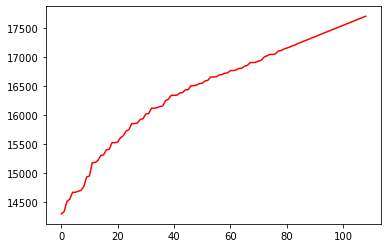

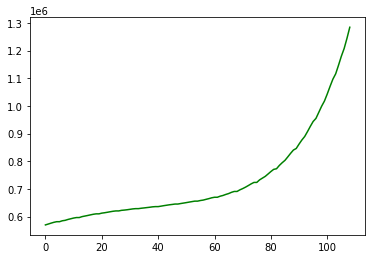

49 15
Minnesota 0.03390434381735513 0.11145915202182613


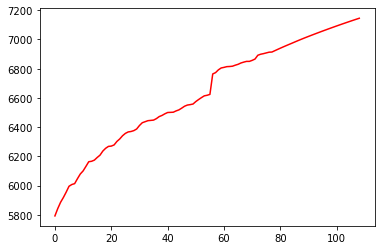

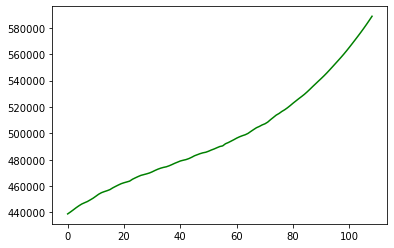

48 49
Mississippi 0.026243310161788273 0.04872160528149583


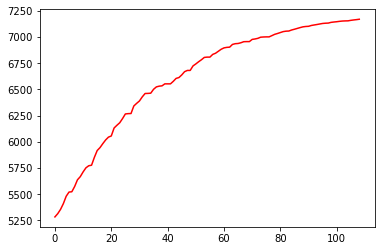

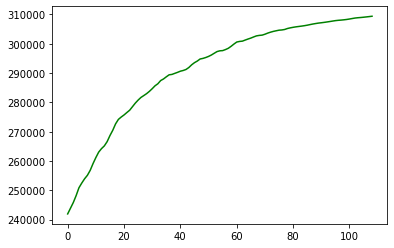

47 49
Missouri 0.026428671743484827 0.18943873417289298


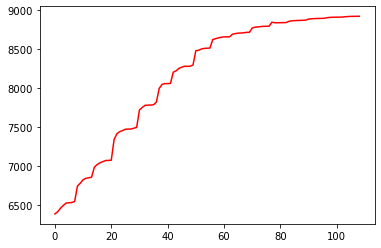

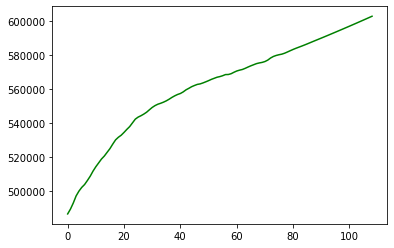

33 49
Montana 0.05537376310985543 0.12260947876978398


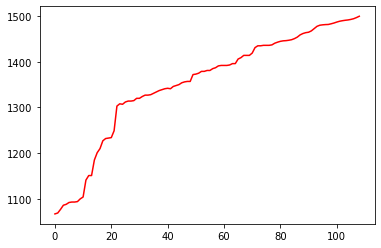

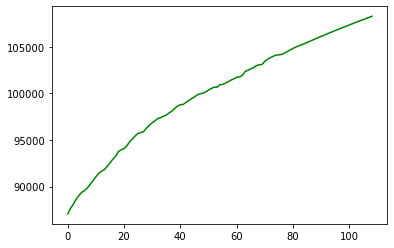

47 42
Nebraska 0.03464906995234636 0.1684486173723246


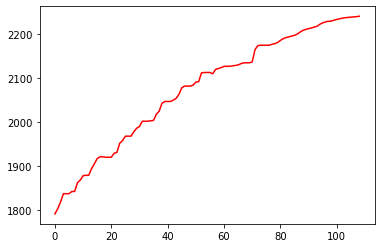

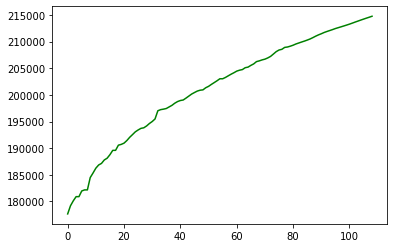

47 49
Nevada 0.02625619671978191 0.04685885255274012


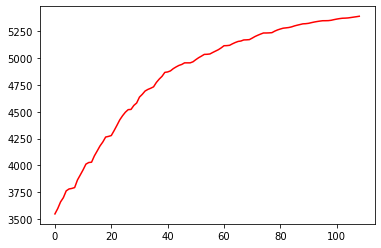

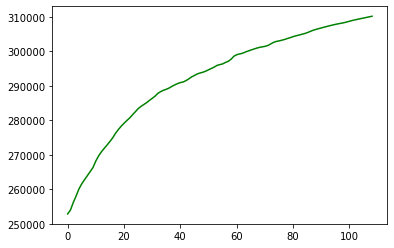

49 49
New Hampshire 0.05043764900709243 0.10358281598251846


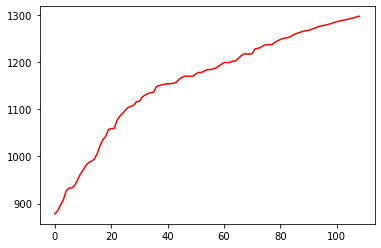

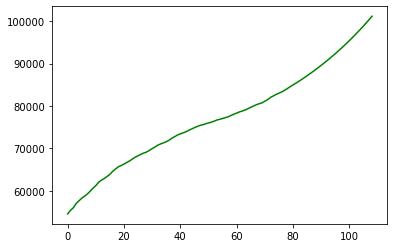

38 42
New Jersey 0.044563399037104226 0.042354440212081644


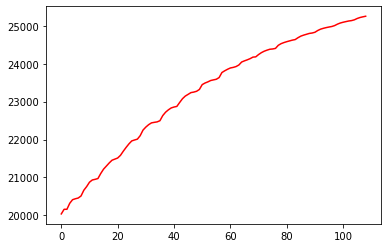

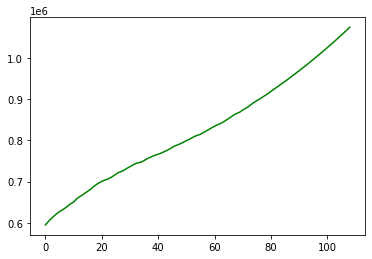

49 46
New Mexico 0.013981317270965035 0.07394646983645327


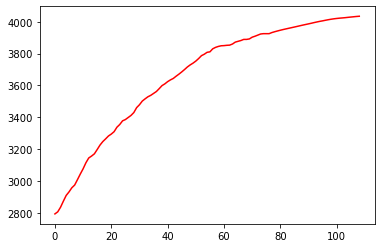

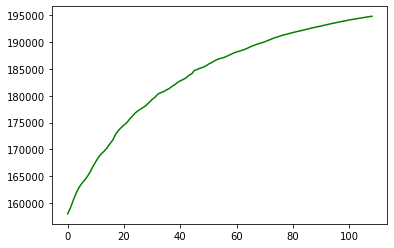

19 28
New York 0.09893895697308283 0.03691852874162503


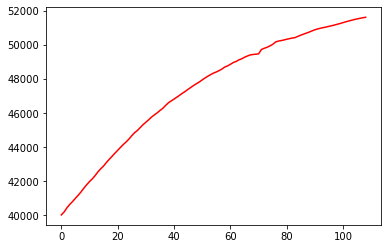

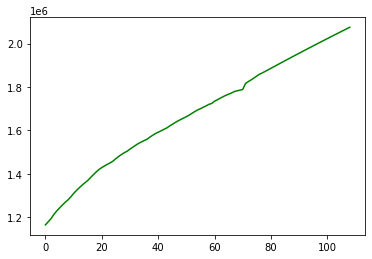

49 48
North Carolina 0.08017633621315745 0.12443960483477688


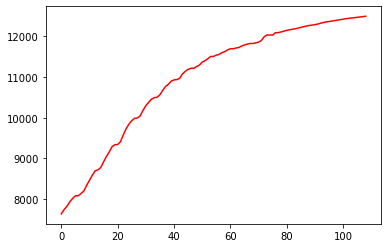

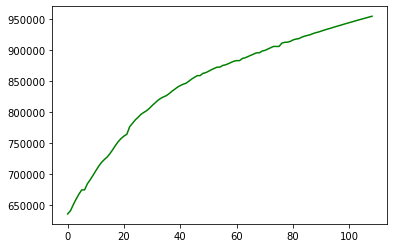

47 40
North Dakota 0.02900948052147317 0.03817385711741672


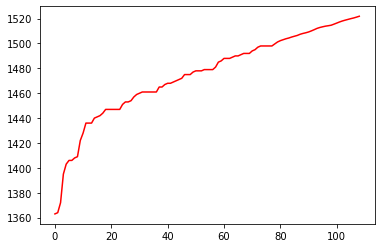

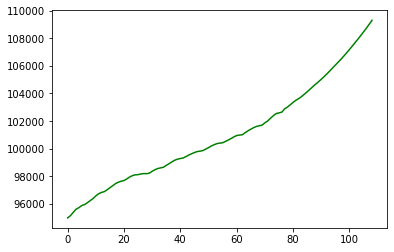

46 49
Ohio 0.029727845390127187 0.008907300686784293


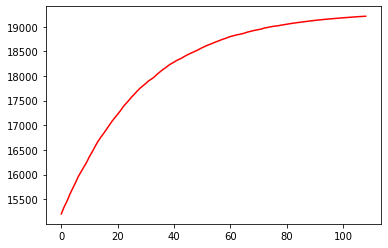

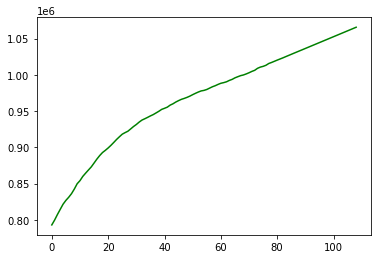

49 48
Oklahoma 0.028790845707806448 0.34555758696580324


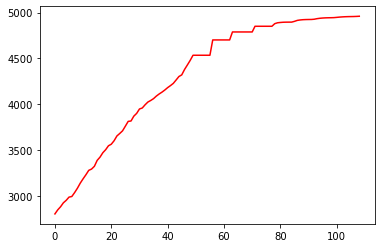

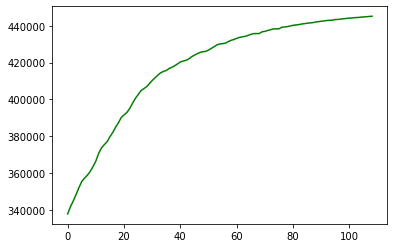

48 49
Oregon 0.04301727193443275 0.14886916576243375


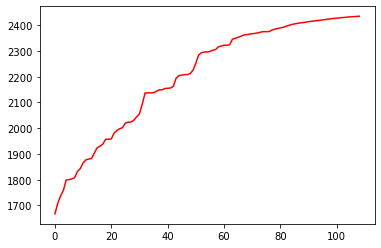

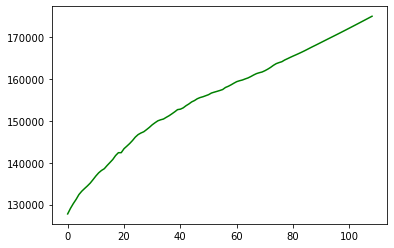

39 49
Pennsylvania 0.0637020818386345 0.043624736149185286


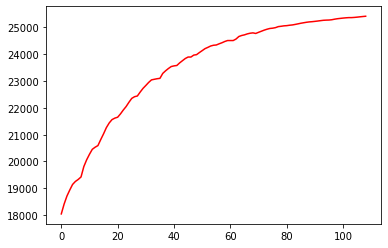

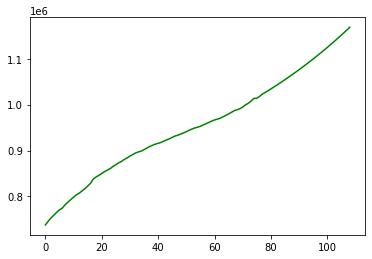

49 48
Rhode Island 0.04420454954460665 0.062002488370259096


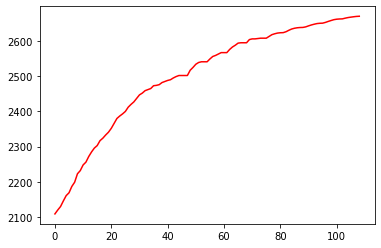

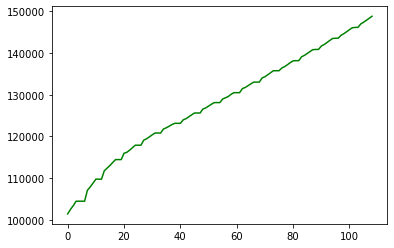

49 49
South Carolina 0.0397024815792418 0.07498583756975793


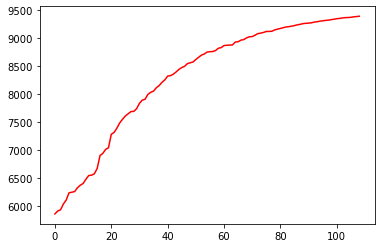

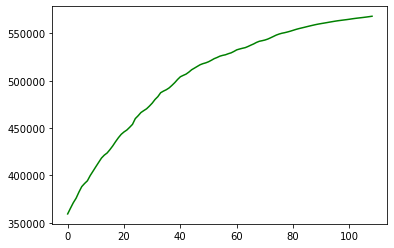

36 49
South Dakota 0.03372706350165403 0.0452374238320794


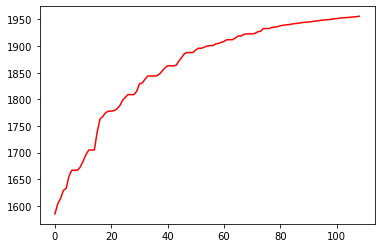

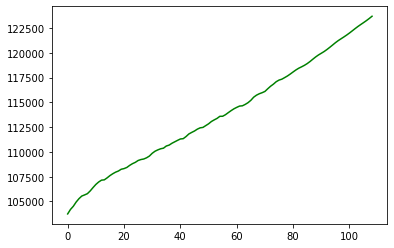

49 48
Tennessee 0.04433803378122649 0.0927525385950714


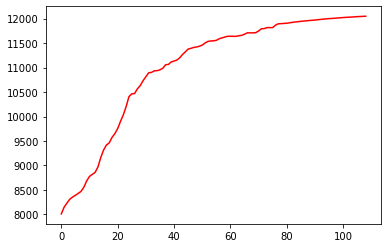

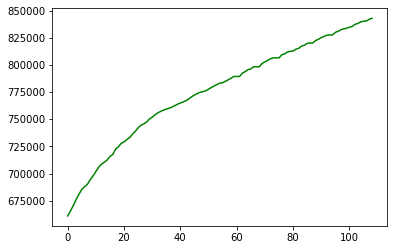

47 49
Texas 0.027460309121229407 0.05161877012489807


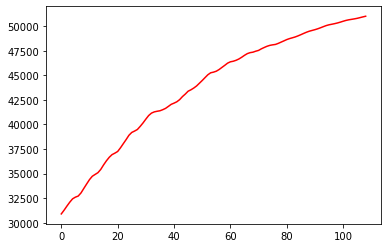

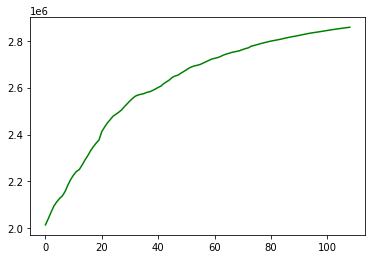

49 49
Utah 0.014002375453149894 0.1163094132597636


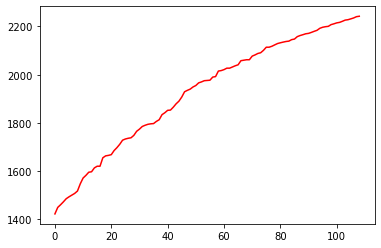

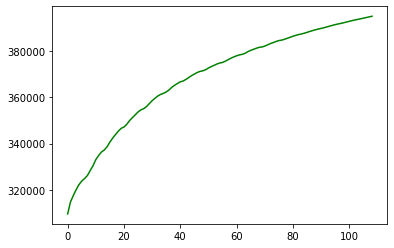

42 47
Vermont 0.17965124403260707 0.23014201677973656


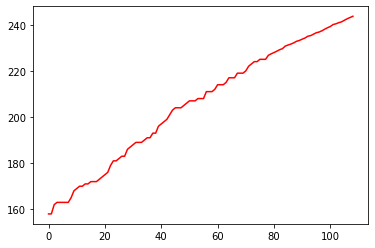

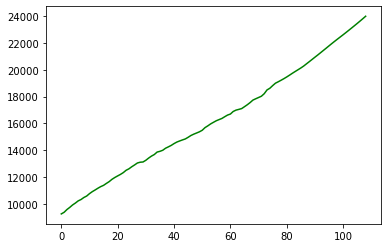

48 47
Virginia 0.03244071863069484 0.2778677625932511


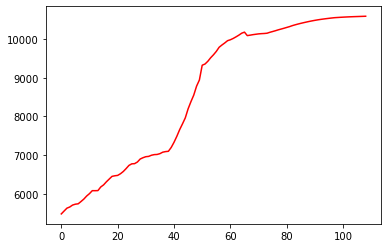

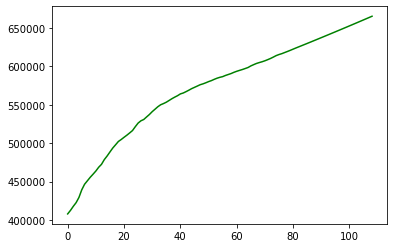

47 46
Washington 0.06012341247036296 0.04315027619775634


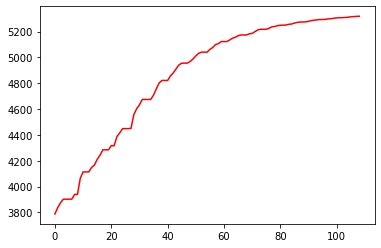

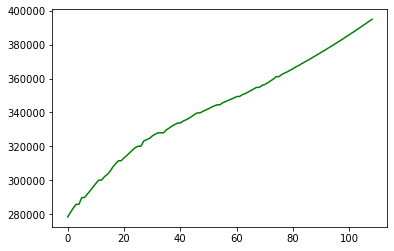

49 8
West Virginia 0.03051089422822426 0.3953718192245534


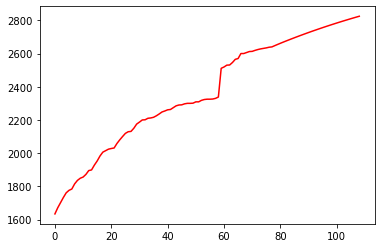

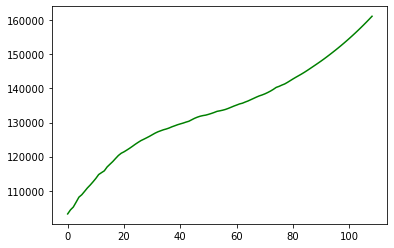

47 49
Wisconsin 0.02618499321424412 0.04751291074296926


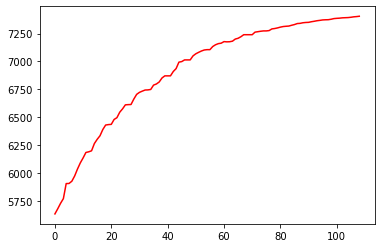

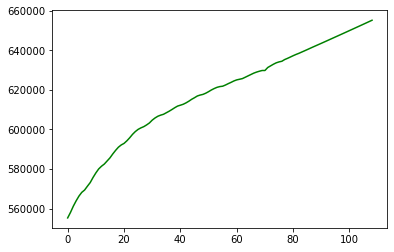

49 49
Wyoming 0.04276877330507304 0.1284279824127698


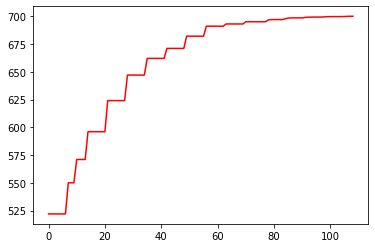

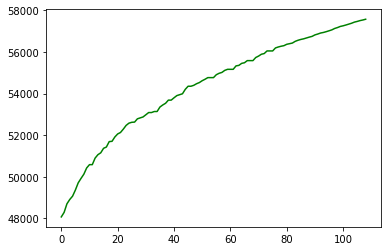

In [31]:
# autoregressive
def optimize_state(state):
    new_f = states_df_og[state][["Confirmed", "Deaths"]].reset_index(drop=True)
    deaths = new_f["Deaths"].to_numpy()
    confirmed = new_f["Confirmed"].to_numpy()
    best_score_c = 100
    best_score_d = 100
    best_lr_d = None
    best_lr_c = None
    best_win_d = 0
    best_win_c = 0
    for win_len in range(5, 50):
        # [0, ..., win_len - 1 ] -> [win_len]
        # [1, ..., win_len] -> [win_len+1]
        # ...
        labels_d = []
        features_d = []
        for i in range(win_len, len(deaths)):
            labels_d.append(deaths[i])
            feature = []
            for j in range(win_len, 0, -1):
                feature.append(deaths[i-j])
            features_d.append(feature)
        #lr = SVR(kernel='linear', max_iter=3000, C=2)
        #lr = Ridge(alpha=0.015, normalize=True)
        lr = LinearRegression(positive=True)
        lr.fit(features_d, labels_d)
        labels_dp = lr.predict(features_d)
        score_d = mean_absolute_percentage_error(labels_dp, labels_d) 
        if score_d < best_score_d:
            best_score_d = score_d
            best_lr_d = lr
            best_win_d = win_len
        
        labels_c = []
        features_c = []
        for i in range(win_len, len(confirmed)):
            labels_c.append(confirmed[i])
            feature = []
            for j in range(win_len, 0, -1):
                feature.append(confirmed[i-j])
            features_c.append(feature)
        #lr2 = Ridge(alpha=0.01)
        lr2 = LinearRegression(positive=True)
        lr2.fit(features_c, labels_c)
        labels_cp = lr2.predict(features_c)
        score_c = mean_absolute_percentage_error(labels_cp, labels_c) 
        if score_c < best_score_c:
            best_score_c = score_c
            best_lr_c = lr2
            best_win_c = win_len
            
    start_date = pd.to_datetime("03-31-2021")
    print(best_win_c, best_win_d)
    print(state, best_score_c*100, best_score_d*100)
    for d in range(31):
        feature_d = deaths[len(deaths)-best_win_d:].reshape(1, -1)
        feature_c = confirmed[len(confirmed)-best_win_c:].reshape(1, -1)
        new_d = best_lr_d.predict(feature_d)
        new_c = best_lr_c.predict(feature_c)
        deaths = np.append(deaths, new_d)
        confirmed = np.append(confirmed, new_c)
        
        date = start_date + timedelta(days=d)
        entry = test_data[(test_data["Province_State"]==state) & (pd.to_datetime(test_data["Date"]) ==date)]
        if not entry.index.empty:
            test_id = entry.index[0]
            sub_data.loc[test_id,["Confirmed"]] = new_c
            sub_data.loc[test_id,["Deaths"]] = new_d
   
    x_s = np.arange(0, len(deaths))
    plt.plot(x_s, deaths, color="red")
    plt.show()
    plt.plot(x_s, confirmed, color="green")
    plt.show()
    
for state in states_df:
    optimize_state(state)

In [38]:
bad_states = ["Kentucky"]
for state in bad_states:
     linear(state)   
sub_data.to_csv("./Team8.csv", index=False) 

Kentucky 2.336081890904751 2.142434152741236


In [33]:
# below are not used

In [34]:
# SEIRS simulator
def simulate_with_params(r_r, e_r, i_r, ri_r, cd_r, v_r, S_0, E_0, I_0, R_0, V_0, D_0, iter=150, d_t=1):
    '''
    e_r: exposed rate for susceptible
    i_r: infection rate for exposed
    r_r: recover rate for infected
    ri_r: reinfection rate for recovered
    cd_r: covid death rate for infected
    v_r: vaccination rate for general population
    S_0: initial susceptible population
    I_0: initial infected population
    R_0: initial recoved population
    D_0: initial deceased population
    V_0: initial vaccinated population

    Derive the trends of S, I, R, V, D with various rates and initial conditions over a period of time
    '''
    S, E, I, R, V, D = [S_0], [E_0], [I_0], [R_0], [V_0], [D_0]
    for i in range(1, iter):
        S_old, E_old, I_old, R_old, D_old, V_old = S[-1], E[-1], I[-1], R[-1], D[-1], V[-1]
        N_old = S_old + E_old + I_old + R_old + V_old
        S_new = S_old + (-e_r*(S_old * I_old) / N_old + ri_r*R_old - v_r*S_old) * d_t
        E_new = E_old + (e_r*(S_old * I_old) / N_old - e_r * E_old) * d_t
        I_new = I_old + (e_r * E_old - cd_r * I_old - r_r * I_old) * d_t
        R_new = R_old + (r_r*I_old - ri_r*R_old) * d_t
        D_new = D_old + (cd_r * I_old) * d_t
        V_new = V_old + (v_r * S_old) * d_t
        S.append(S_new)
        E.append(E_new)
        I.append(I_new)
        R.append(R_new)
        D.append(D_new)
        V.append(V_new)
    return S, E, I, R, V, D

In [35]:
def plot_data(S, E, I, R, V, D, d_t=1, with_S=True, title=None):
    '''
    S: list of number of susceptible people
    E: list of number of exposed people
    I: list of number of infected people
    R: list of number of recovered people
    V: list of number of vaccinated people
    D: list of number of deceased people

    Based on the data, plot the corresponding graph
    '''
    x_axis = np.arange(0, len(S), d_t)
    fig, ax = plt.subplots()
    if with_S:
        ax.plot(x_axis, S, 'g-', label="S (susceptible)")
    ax.plot(x_axis, E, 'm-', label="E (exposed)")
    ax.plot(x_axis, I, 'r-', label="I (infected)")
    ax.plot(x_axis, R, 'y-', label="R (recovered)")
    ax.plot(x_axis, V, 'b-', label="V (vaccinated)")
    ax.plot(x_axis, D, 'k-', label="D (deceased)")
    leg = ax.legend()
    plt.xlabel("Time elasped (day)")
    plt.ylabel("Number of people")
    plt.title(title)
    plt.show()

In [36]:
# example
    
def origin_trend(state):
    S = states_df[state]["Susceptible"]
    I = states_df[state]["Active"]
    R = states_df[state]["Recovered"]
    D = states_df[state]["Deaths"]
    V = states_df[state]["Vaccinated"]
    plot_data(S, I, R, V, D, with_S=False)

In [37]:
def cost_function (params, S, I, R, D, V, hib):
    '''
    params: [r_r, e_r, i_r, ri_r, cd_r, v_r]
    '''
    S_p, E_p, I_p, R_p, V_p, D_p = simulate_with_params(params[0], params[1], params[2], params[3], params[4], params[5], S[0], I[hib], I[0], R[0], V[0], D[0], iter=len(S))
    cost = mean_absolute_percentage_error(I_p, I) + mean_absolute_percentage_error(R_p, R) + mean_absolute_percentage_error(D_p, D)
    return cost

def optimize_state(state, with_plot=False):
    S = states_df[state]["Susceptible"].reset_index(drop=True)
    I = states_df[state]["Active"].reset_index(drop=True)
    R = states_df[state]["Recovered"].reset_index(drop=True)
    D = states_df[state]["Deaths"].reset_index(drop=True)
    V = states_df[state]["Vaccinated"].reset_index(drop=True)
    res = minimize(cost_function, [0, 0, 0, 0, 0, 0], (S, I, R, D, V, 7), bounds=[(0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1)])
    params = res.x
    cost = cost_function(params, S, I, R, D, V, 10)
    S_p, E_p, I_p, R_p, V_p, D_p = simulate_with_params(params[0], params[1], params[2], params[3], params[4], params[5], S[0], I[10], I[0], R[0], V[0], D[0], iter=150)
    if with_plot:
        plot_data(S_p, E_p, I_p, R_p, V_p, D_p, with_S=False)
        plot_data(S, [0]*len(S), I, R, V, D, with_S=False)
    return params, cost, (S_p, E_p, I_p, R_p, V_p, D_p)

def test_performance(state, preds, start=54, end=78):
    S_p, E_p, I_p, R_p, V_p, D_p = preds
    S_r = S_p[start:end]
    I_r = I_p[start:end]
    R_r = R_p[start:end]
    D_r = D_p[start:end]
    C_r = np.sum(np.array([I_r, R_r, D_r]), axis=0)
    D = states_df_og[state]["Deaths"][start:end]
    C = states_df_og[state]["Confirmed"][start:end]
    cost_D = mean_absolute_percentage_error(D_r, D)
    cost_C = mean_absolute_percentage_error(C_r, C)
    return cost_D + cost_C

def save_result(state, preds, start=79, end=109):
    S_p, E_p, I_p, R_p, V_p, D_p = preds
    start_date = pd.to_datetime("01-12-2021")
    for i in range(start, end):
        date = start_date + timedelta(days=i)
        entry = test_data[(test_data["Province_State"]==state) & (pd.to_datetime(test_data["Date"]) ==date)]
        test_id = entry.index[0]
        sub_data.loc[test_id,["Confirmed"]] = I_p[i] + R_p[i] + D_p[i]
        sub_data.loc[test_id, ["Deaths"]] = D_p[i]